<a href="https://colab.research.google.com/github/simon-mellergaard/RL/blob/main/Project/Project03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

This notebook contains the third project assignment. You work on the project in groups. You should already have formed a group. If not, do it on Brightspace under *My Courses > Groups*. To get started, do the following steps:

1) One student in the group makes a copy of this notebook.
2) Share it with your group using *Share* top-right. Here, add group members under people with access.
3) Moreover, under *Share > General access*, choose *Anyone with the link > Commenter*. Copy this link and paste it below.
4) Work with the notebook and solve the tasks.
5) Hand in the notebook by downloading it: File > Download > Download .ipynb. Next, on BS under *Project*, upload the file (I need that for the exam). Moreover, add the shared link of your Colab notebook as a link when you handin too.
6) After hand-in do peer grading (see BS under *Project*)

Sharing link: https://colab.research.google.com/drive/1PRaVnhYL1ELaXfEXdsvQSRiOIQXNqQsF?usp=sharing

**Deadlines**

* Hand-in solution 7/12/25
* Peer grading 13/12/25


# Notebook pre steps

In [ ]:
#@title Installations

# install missing packages
!pip install -q dfply

import numpy as np
import gdown
import gzip
import pandas as pd
import itertools
import joblib
import warnings
from dfply import *
from IPython.display import Markdown
from plotnine import *
from pprint import pprint
from scipy.stats import norm
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 12.3 MB/s eta 0:00:00


# Problem description

Consider the [Hour-to-hour electricity market problem](https://colab.research.google.com/drive/1BFI6iRLTnrHgxgFayC89SKhuM3XcIp7s?usp=sharing) that we solved using a Markov decision process by discretising the state and action space.

Here, we are going to solve the problem using RL with approximation. How to solve the problem depends on which environment your are using. You may use one of the following environment for the problem:

1. The environment given in [Project 2](https://colab.research.google.com/drive/1HhQbV2ZvfMsEv-RkoGS6Sj0mjzC9QYF8?usp=sharing) which uses a discretization of both states and actions,
2. The environment given in the section "Environment with discrete actions" below.
3. The environment given in the section "Environment with continuous actions" below.

In all environments we represent state and actions using tuples $s_t = (s^l_t,s^c_t,s^w_t,s^p_t)$ and $a_t = (a^b_t, a^w_t, a^c_t)$. Moreover, we use settings:

# Environment with discrete actions

We here use an environment where

1. The battery only can be charged/discharged in units of $\delta$, e.g. $\delta = 1$ MWh. That is, $a^b_t \in \{-b^{\max}, \ldots, -\delta, 0, \delta, ..., b^{\max} \}$
2. Due to 1, the battery level is $s^l_t \in \{ 0, \delta, 2\delta, ..., b^{\max} \}$.
3. The same units are used for the wind energy production $a^w_t \in \{ 0, \delta, 2\delta, ..., p^{\max} \}$.
4. Due to 1-3, the commitment levels are $s^c_t \in \{ -b^\max, \ldots, -\delta, 0, \delta, \ldots, b^{\max} + p^{\max}\}$ since we can at most buy energy for an empty battery and we can at most sell max wind production plus a full battery. That is, $a^c_t$ have these commitment levels.

Note $\delta$ must satisfy that $b^{\max}/\delta$ and $p^{\max}/\delta$ are integer. Moreover, when calculating $E(x)$, its value must be rounded down so contained in the set defined for $a^w_t$.

To specify the discrete actions we only need to specify sets for the wind and commitment levels. Hence the battery levels will automatically be discrete too.

The environment is implemented below.


In [ ]:
class EnvEnergyDiscrete:
    """
    Environment for the hour-to-hour electricity market problem with discrete actions.
    """

    def __init__(self, settings, a_w_tuple, a_c_tuple, seed = 25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            a_w_tuple (list): A list of possible wind usage
            a_c_tuple (list): A list of possible commitment levels


            seed (int): A seed for the random number generator
        """
        self.settings = settings

        ## price model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        # Output filename for the downloaded file
        output_filename = 'prices_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        print(f"Price model loaded successfully from {output_filename}")
        self.model_price = model_price

        ## wind model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        # Output filename for the downloaded file
        output_filename = 'wind_log_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        print(f"Wind model loaded successfully from {output_filename}")
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)

        self.a_c_tuple = a_c_tuple
        self.a_w_tuple = a_w_tuple

    def reset_rng(self, seed):
        """
        Reset the random number generator.

        Args:
            seed (int): A seed for the random number generator
        """
        self.rng = np.random.default_rng(seed)

    def get_left(self, sorted_list, a):
        """
        Given a sorted list and a number 'a', finds the largest number 'b' in
        the list so b <= a

        Args:
            sorted_list (list): A list of numbers sorted in ascending order.
            a (float or int): The number to find the bounds for.

        Returns:
            float or int: The largest number 'b' in the list so b <= a.
        """
        # Iterate through the sorted list to find the bounds
        for i in range(len(sorted_list)-1, -1, -1):
            if sorted_list[i] <= a:
                return sorted_list[i]
        return None

    def get_actions(self, s: tuple) -> list:
        """
        Get all possible actions for a given state.
        """
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']
        # Determine a_b and a_w
        e_max = self.get_left(self.a_w_tuple, self.energy(s_w)) # max energy we can sell/produce (e.g. if energy(s_w) = 1.25 but a_w_tuple is [0,1,2,...] then can only sell 1)
        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else: # s_c < e_max:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else: # s_c < 0:
            a_b = -min(b_max - s_l, - s_c + e_max)
            a_w = max(0, - a_b + s_c)

        actions = [(float(a_b), float(a_w), float(a_c)) for a_c in self.a_c_tuple if a_c >= -(b_max - (s_l - a_b))]
        # if -(b_max - (s_l - a_b)) > -10:
        #     print(f"s_c: {s_c},  s_w: {s_w}, e_max: {e_max}")
        #     print(f"s_l: {s_l}, a_b: {a_b}, a_w: {a_w}, min a_c: {-(b_max - (s_l - a_b))}")
        #     print(min([a[2] for a in actions]))
        return actions

    def state_variables_to_str(self, s_l, s_c, s_w, s_p):
        """
        String representaion of a state.
        """
        return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

    def action_variables_to_str(self, a_b, a_w, a_c):
        """
        String representaion of an action.
        """
        return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def energy_inverse(self, energy_target, time_period_length = 1):
        """
        Find the wind speed that produces a given amount of energy, assuming wind is between w_cut_in and w_rated.

        Args:
            energy_target (float): The target energy output in MWh.
            time_period_length (float, optional): The time period length in hours. Defaults to 1.

        Returns:
            float: The wind speed that produces the given energy.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']

        if energy_target < 0 or energy_target > p_max:
            return None

        def find_wind_speed(w):
            return self.energy(w, time_period_length) - energy_target

        sol = root_scalar(find_wind_speed, bracket=[w_cut_in, w_rated], method='brentq')
        return sol.root if sol.converged else None


    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        if s_p < 0:
            return s_c * s_p - c_minus * abs(s_c - e)
        raise ValueError("Reward can not be calculated.")

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.

        Args:
            price (float): The current price.

        Returns:
            float: A random sample of the next hour's price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        # The mean of the next price's distribution is the predicted value
        mean_next_price = intercept + phi * price
        # The standard deviation of the next price's distribution is the residual standard deviation
        std_dev_next_price = sigma
        # Generate a random sample from a normal distribution
        price_next_sample = self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)
        return price_next_sample

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.

        Args:
            wind (float): The current wind speed.

        Returns:
            float: A random sample of the next hour's wind speed.
        """
        # Add a small epsilon to prevent log(0) if wind is zero.
        # This ensures numerical stability for the log-transformed AR(1) model.
        min_positive_wind = 1e-6 # A very small positive number to avoid log(0)
        log_wind = np.log(max(wind, min_positive_wind))
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        # The mean of the next wind speed's distribution is the predicted value
        log_mean_next_wind = intercept + phi * log_wind
        # The standard deviation of the next wind speed's distribution is the residual standard deviation
        std_dev_next_wind = sigma
        # Generate a random sample from a normal distribution
        log_wind_next_sample = self.rng.normal(loc=log_mean_next_wind, scale=std_dev_next_wind)
        return np.exp(log_wind_next_sample)

    def get_step(self, s: tuple, a: tuple):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label
            a: Action label

        Returns:
            tuple: (sN, r)
        """
        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a
        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w)) # update current values
        s_p_next = float(self.generate_price_next_hour(s_p))
        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward


Let us create an instance of the class:

In [ ]:
def generate_discrete_set(min_val, max_val, step):
    """
    Generates a set of discrete values from min_val to max_val with step size.

    Args:
        min_val (float): The minimum value in the set.
        max_val (float): The maximum value in the set.
        step (float): The step size between consecutive values.

    Returns:
        set: A set of discrete values {min_val,…,−𝛿,0,𝛿,...,max_val}.
    """
    # Ensure step is a divisor of min_val
    if not np.isclose(min_val % step, 0):
        raise ValueError("min_val argument must be divisible by step.")
    if not np.isclose(max_val % step, 0):
        raise ValueError("max_val argument must be divisible by step.")
    return np.arange(min_val, max_val + step, step)

# These settings could be changed (not in original code)
settings = {
    'b_max': 10,  # battery capacity (MWh)
    'p_max': 10,  # max power output wind (MW)
    'c_max': 10 + 10,  # max commitment (MWh) # b_max + p_max
    'w_cut_in': 3,  # cut in wind speed (m/s)
    'w_rated': 12,  # rated wind speed (m/s)
    'w_cut_out': 25,  # cut out wind speed (m/s)
    'c_plus': 50,  # EUR/MWh
    'c_minus': 50, # EUR/MWh
}

step_mwh = 2
b_max = settings['b_max']
p_max = settings['p_max']
c_max = settings['c_max']
a_w_tuple = generate_discrete_set(0, p_max, step_mwh)
a_c_tuple = generate_discrete_set(-b_max, c_max, step_mwh)

envD = EnvEnergyDiscrete(settings, a_w_tuple = a_w_tuple, a_c_tuple = a_c_tuple)

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


## Q1

Consider the code below and explain the output.

In [ ]:
#@title Solution

import random

s = [4.0, 6.0, 12.4, 34.7] #  s = (s_l, s_c, s_w, s_p)
np.random.seed(0)
for _ in range(5):
    actions = envD.get_actions(s)  # a = (a_b, a_w, a_c)
    a = random.choice(actions)
    print(f"(s_l, s_c, s_w, s_p): {s}, (a_b, a_w, a_c): {a} ->", end = " ")
    s, r = envD.get_step(s, a)
    s = [round(v,1) for v in s]
    a = [round(v,0) for v in a]
    print(f"{s}, Rew: {r:1.1f}")


(s_l, s_c, s_w, s_p): [4.0, 6.0, 12.4, 34.7], (a_b, a_w, a_c): (-4.0, 10.0, 20.0) -> [8.0, 20.0, 7.9, 31.3], Rew: 208.2
(s_l, s_c, s_w, s_p): [8.0, 20.0, 7.9, 31.3], (a_b, a_w, a_c): (8.0, 0.0, 10.0) -> [0.0, 10.0, 48.0, 39.0], Rew: 26.0
(s_l, s_c, s_w, s_p): [0.0, 10.0, 48.0, 39.0], (a_b, a_w, a_c): (0.0, 0.0, 2.0) -> [0.0, 2.0, 16.0, 55.7], Rew: -110.0
(s_l, s_c, s_w, s_p): [0.0, 2.0, 16.0, 55.7], (a_b, a_w, a_c): (-8.0, 10.0, 8.0) -> [8.0, 8.0, 1.7, 56.9], Rew: 111.4
(s_l, s_c, s_w, s_p): [8.0, 8.0, 1.7, 56.9], (a_b, a_w, a_c): (8.0, 0.0, -2.0) -> [0.0, -2.0, 0.1, 69.6], Rew: 455.2


In [ ]:
display(Markdown("""
We start in the state where we have 4.0 MWh in battery, and the commitment levels
is 6 MW. The wind speed is 12.4 m/s and price 34.7. We then choose a random
action among the possible actions, and print. We obseve the reward and the
next state, which is printed. We observe a reward of 208, as this is the power
we sell $6 * 34.7 = 208.2$. This is repeated 5 times.

The next state we have a commitment of 20, as this was the commitment action
chosen in the previous period. It then chooses another commitment level at
random (10MW), and we observe the reward again. This is a low reward, as we have
a big imbalance, as we have a big imablance (commiting 8 when we have commited 20).
This continues for 5 iterations.

We do not generate wind energy in the third iteration, as it is above the
w_cut_out limit.
"""))


We start in the state where we have 4.0 MWh in battery, and the commitment levels
is 6 MW. The wind speed is 12.4 m/s and price 34.7. We then choose a random
action among the possible actions, and print. We obseve the reward and the 
next state, which is printed. We observe a reward of 208, as this is the power 
we sell $6 * 34.7 = 208.2$. This is repeated 5 times.

The next state we have a commitment of 20, as this was the commitment action
chosen in the previous period. It then chooses another commitment level at
random (10MW), and we observe the reward again. This is a low reward, as we have
a big imbalance, as we have a big imablance (commiting 8 when we have commited 20).
This continues for 5 iterations.

We do not generate wind energy in the third iteration, as it is above the
w_cut_out limit. 


# Environment with continuous actions

We here use an environment where both actions and states are continuous.

The environment is implemented below.


In [ ]:
class EnvEnergyCont:
    """
    Environment for the hour-to-hour electricity market problem with continuous actions.
    """

    def __init__(self, settings, seed = 25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            seed (int): A seed for the random number generator
        """
        self.settings = settings

        ## price model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        # Output filename for the downloaded file
        output_filename = 'prices_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        print(f"Price model loaded successfully from {output_filename}")
        self.model_price = model_price

        ## wind model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        # Output filename for the downloaded file
        output_filename = 'wind_log_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        print(f"Wind model loaded successfully from {output_filename}")
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)

    def reset_rng(self, seed):
        """
        Reset the random number generator.

        Args:
            seed (int): A seed for the random number generator
        """
        self.rng = np.random.default_rng(seed)

    def check_s(self, s):
        """
        Check if a state is valid.
        """
        s_l, s_c, s_w, _ = s
        assert s_l >= 0 and s_l <= self.settings['b_max']
        assert s_c >= -self.settings['b_max'] and s_c <= self.settings['c_max']
        assert s_w >= 0

    def check_a(self, a):
        """
        Check if an action is valid.
        """
        a_b, a_w, a_c = a
        assert a_b >= -self.settings['b_max'] and a_b <= self.settings['b_max']
        assert a_w >= 0
        assert a_c >= -self.settings['b_max'] and a_c <= self.settings['c_max']

    def get_action_info(self, s: tuple) -> tuple:
        """
        Get fixed actions for a given state and the minimum a_c value to choose.
        """
        self.check_s(s)
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']
        # Determine a_b and a_w
        e_max = self.energy(s_w) # max wind energy we can sell/produce
        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else: # s_c < e_max:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else: # s_c < 0:
            a_b = -min(b_max - s_l, - s_c + e_max)
            a_w = max(0, - a_b + s_c)
        # print(f"s_c: {s_c},  s_w: {s_w}, e_max: {e_max}")
        # print(f"s_l: {s_l}, a_b: {a_b}, a_w: {a_w}, min a_c: {-(b_max - (s_l - a_b))}")
        a_c_min = -(b_max - (s_l - a_b))  # no need to buy power that cannot be stored
        return float(a_b), float(a_w), float(a_c_min)

    def state_variables_to_str(self, s_l, s_c, s_w, s_p):
        """
        String representaion of a state.
        """
        return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

    def action_variables_to_str(self, a_b, a_w, a_c):
        """
        String representaion of an action.
        """
        return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        if s_p < 0:
            return s_c * s_p - c_minus * abs(s_c - e)
        raise ValueError("Reward can not be calculated.")

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.

        Args:
            price (float): The current price.

        Returns:
            float: A random sample of the next hour's price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        # The mean of the next price's distribution is the predicted value
        mean_next_price = intercept + phi * price
        # The standard deviation of the next price's distribution is the residual standard deviation
        std_dev_next_price = sigma
        # Generate a random sample from a normal distribution
        price_next_sample = self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)
        return price_next_sample

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.

        Args:
            wind (float): The current wind speed.

        Returns:
            float: A random sample of the next hour's wind speed.
        """
        # Add a small epsilon to prevent log(0) if wind is zero.
        # This ensures numerical stability for the log-transformed AR(1) model.
        min_positive_wind = 1e-6 # A very small positive number to avoid log(0)
        log_wind = np.log(max(wind, min_positive_wind))
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        # The mean of the next wind speed's distribution is the predicted value
        log_mean_next_wind = intercept + phi * log_wind
        # The standard deviation of the next wind speed's distribution is the residual standard deviation
        std_dev_next_wind = sigma
        # Generate a random sample from a normal distribution
        log_wind_next_sample = self.rng.normal(loc=log_mean_next_wind, scale=std_dev_next_wind)
        return np.exp(log_wind_next_sample)

    def get_step(self, s: tuple, a: tuple):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label
            a: Action label

        Returns:
            tuple: (sN, r)
        """
        self.check_s(s)
        self.check_a(a)
        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a
        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w)) # update current values
        s_p_next = float(self.generate_price_next_hour(s_p))
        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        self.check_s(s_next)
        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward


Let us create an instance of the class:

In [ ]:
envC = EnvEnergyCont(settings)

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


## Q2

Consider the code below and explain the output.

In [ ]:
#@title Solution

import random

s = [4.6, 12.7, 12.4, 34.7] #  s = (s_l, s_c, s_w, s_p)
for _ in range(5):
    a_b, a_w, a_c_min = envC.get_action_info(s)  # a = (a_b, a_w, a_c)
    a_c = random.uniform(a_c_min, c_max)
    a = (a_b, a_w, a_c)
    a = [round(v,1) for v in a]
    print(f"(s_l, s_c, s_w, s_p): {s}, (a_b, a_w, a_c): {a} ->", end = " ")
    s, r = envC.get_step(s, a)
    s = [round(v,1) for v in s]
    print(f"{s}, Rew: {r:1.1f}")

(s_l, s_c, s_w, s_p): [4.6, 12.7, 12.4, 34.7], (a_b, a_w, a_c): [2.7, 10.0, 0.2] -> [1.9, 0.2, 12.4, 25.5], Rew: 440.7
(s_l, s_c, s_w, s_p): [1.9, 0.2, 12.4, 25.5], (a_b, a_w, a_c): [-8.1, 8.3, 13.7] -> [10.0, 13.7, 14.3, 55.8], Rew: 5.1
(s_l, s_c, s_w, s_p): [10.0, 13.7, 14.3, 55.8], (a_b, a_w, a_c): [3.7, 10.0, 8.2] -> [6.3, 8.2, 1.6, 46.7], Rew: 764.5
(s_l, s_c, s_w, s_p): [6.3, 8.2, 1.6, 46.7], (a_b, a_w, a_c): [6.3, 0.0, -1.6] -> [0.0, -1.6, 16.1, 25.5], Rew: 287.9
(s_l, s_c, s_w, s_p): [0.0, -1.6, 16.1, 25.5], (a_b, a_w, a_c): [-10.0, 8.4, 13.5] -> [10.0, 13.5, 12.4, 57.4], Rew: -40.8


In [ ]:
display(Markdown("""
The code is very similar, but in this case we have a continuous action space,
meaning that we can choose decimal numbers for how much power we sell and buy.
We therefore choose a random decimal between the minimum possible commitment
and the maximum commitment possible. The decimal is then rounded to .1.

We start in the state with a battery level of 4.6 and a commitment of 12.7.
We then choose to sell 2.7 from the battery and 10 from the wind, which leaves
us without an imbalance, and we have a reward of $440.7. The next period
we only choose to commit 0.2, which is a low number, and we therefore only
have a small reward here. As we have excess wind energy, we charge the battery
by 8.1MW.

This is repeated 5 times, and we end in a state where we have a battery
level of 10MW, and a commitment level of 13.5MW.
"""))


The code is very similar, but in this case we have a continuous action space,
meaning that we can choose decimal numbers for how much power we sell and buy.
We therefore choose a random decimal between the minimum possible commitment
and the maximum commitment possible. The decimal is then rounded to .1.

We start in the state with a battery level of 4.6 and a commitment of 12.7.
We then choose to sell 2.7 from the battery and 10 from the wind, which leaves
us without an imbalance, and we have a reward of $440.7. The next period
we only choose to commit 0.2, which is a low number, and we therefore only
have a small reward here. As we have excess wind energy, we charge the battery
by 8.1MW.

This is repeated 5 times, and we end in a state where we have a battery
level of 10MW, and a commitment level of 13.5MW. 


# Q3 - Solving the problem

Our objective is to maximise the average reward. Pick one of the environments above and solve the problem. Note in theory by having continuous actions, you don't limit your action space and you should be able to get a better objective value.

For solving the problem, you have different options:

1. Implement classes for state-value and policy approximation and apply an actor-critic algorithm, similar to what we have done in the course.
2. Convert the environment into a Gym-style RL environment so it can be used with an RL library. Then, utilise the RL library to solve the problem. Note that in most RL libraries, the objective is discounted reward, which we have argued is not the most suitable choice for continuing problems. However, if you use a discount rate close to 1 (such as 0.9999), you can mimic the average reward objective.

State and clearly connect your choices to (also holds if you use Deep RL):

* The average reward objective.
* Theory regarding state-value approximations.
* Theory about policy approximations.
* Theory used which has not been presented in the course.

ChatGPT (or similar) can be useful for initial guidance, but remember to critically evaluate and understand the reasoning behind your choices. If you require GPU acceleration in Colab, then change the runtime type to GPU-T4 (the dropdown beside RAM in the upper right corner).




# **Option 1: Using continuous action env**

In [ ]:
"""
Actor-Critic Solution for Energy Trading (Continuous Actions)
Differential (average reward) formulation for continuing task
"""

import numpy as np
import pandas as pd
from tqdm import tqdm
from plotnine import *
from dfply import *
import hashlib
from typing import Any, Callable, Optional, Sequence, List

# TileCoder class (from notebook)
class TileCoder:
    """
    A practical TileCoder for RL (1D and ND).
    """

    def __init__(
        self,
        n_tilings: int,
        tiles_per_dim,
        ranges,
        wrap=False,
        seed=None,
        deterministic=True,
        hash_size: int = 4096
    ):
        self.n_tilings = n_tilings
        self.tiles_per_dim = np.array(tiles_per_dim)
        self.ranges = np.array(ranges)
        self.d = len(ranges)
        self.hash_size = hash_size

        # Deterministic offsets
        widths = 1.0 / self.tiles_per_dim
        t = np.arange(n_tilings).reshape(-1, 1)
        self.offsets = (t / n_tilings) * widths

        self.n_features = hash_size

    def _normalize(self, x):
        x = np.array(x)
        lo, hi = self.ranges[:, 0], self.ranges[:, 1]
        return np.clip((x - lo) / (hi - lo), 0, 1)

    def _hash(self, t, idxs):
        payload = np.array([t, *idxs], dtype=np.int64).tobytes()
        h = hashlib.sha256(payload).digest()
        return int.from_bytes(h[:8], 'little') % self.hash_size

    def active_indices(self, x):
        u = self._normalize(x)
        indices = []
        for t in range(self.n_tilings):
            v = u + self.offsets[t]
            idxs = tuple(min(int(np.floor(vi * tpd)), tpd - 1)
                        for vi, tpd in zip(v, self.tiles_per_dim))
            indices.append(self._hash(t, idxs))
        return np.array(indices, dtype=int)

    def encode_sparse(self, x):
        """Return (indices, values) for sparse representation."""
        idxs = self.active_indices(x)
        vals = np.ones(len(idxs), dtype=float)
        return idxs, vals

# Value Function (Tile Coding)
class ValueFunctionTileCoding:
    """
    Value function approximation using tile coding.
    """

    def __init__(
        self,
        env,
        step_size: float,
        n_tilings: int = 8,
        tiles_per_dim: List[int] = [8, 8, 8, 8],
        init_val: float = 0.0,
        seed: int = None
    ):
        self.env = env

        # State ranges for energy environment
        ranges = [
            (0, env.settings['b_max']),                        # s_l
            (-env.settings['b_max'], env.settings['c_max']),   # s_c
            (0, 30),                                            # s_w
            (-50, 150)                                          # s_p
        ]

        self.tc = TileCoder(
            n_tilings=n_tilings,
            tiles_per_dim=tiles_per_dim,
            ranges=ranges,
            seed=seed
        )

        # Learning rate (divide by n_tilings for stability)
        self.alpha = float(step_size) / n_tilings

        # Parameters
        self.n_features = self.tc.n_features

        # Initialize weights so v(s) ≈ init_val
        w0 = init_val / n_tilings
        self.w = np.full(self.n_features, w0, dtype=float)

    def _features(self, s):
        """Sparse tile-coded features (idxs, vals)."""
        return self.tc.encode_sparse(np.asarray(s, dtype=float))

    def eval(self, s) -> float:
        """Return v(s)."""
        idxs, vals = self._features(s)
        return float(np.dot(self.w[idxs], vals))

    def train(self, s, target: float) -> None:
        """
        Semi-gradient TD update toward target:
            δ = target - v(s)
            w <- w + α * δ * x(s)
        """
        idxs, vals = self._features(s)
        v_s = np.dot(self.w[idxs], vals)
        delta = target - v_s
        # Clip delta for stability
        delta = np.clip(delta, -100, 100)
        self.w[idxs] += self.alpha * delta * vals

# Gaussian Policy (Softmax won't work with continuous actions)
class GaussianPolicyTileCoding:
    """
    Gaussian policy for continuous action a_c using tile coding.
    """

    def __init__(
        self,
        env,
        step_size: float,
        n_tilings: int = 8,
        tiles_per_dim: List[int] = [8, 8, 8, 8],
        sigma: float = 2.0,
        init_mean: float = 0.0,
        rng_seed: int = None
    ):
        self.env = env
        self.sigma = sigma
        self.rng = np.random.default_rng(rng_seed)

        # Action bounds
        self.a_c_min_global = -env.settings['b_max']
        self.a_c_max = env.settings['c_max']

        # State ranges
        ranges = [
            (0, env.settings['b_max']),
            (-env.settings['b_max'], env.settings['c_max']),
            (0, 30),
            (-50, 150)
        ]

        self.tc = TileCoder(
            n_tilings=n_tilings,
            tiles_per_dim=tiles_per_dim,
            ranges=ranges
        )

        # Learning rate
        self.alpha = float(step_size) / n_tilings

        # Parameters
        self.n_features = self.tc.n_features

        # Initialize weights so μ(s) ≈ init_mean
        w0 = init_mean / n_tilings
        self.w = np.full(self.n_features, w0, dtype=float)

    def _features(self, s):
        """Sparse tile-coded features."""
        return self.tc.encode_sparse(np.asarray(s, dtype=float))

    def _get_mean(self, s) -> float:
        """Get policy mean μ(s)."""
        idxs, vals = self._features(s)
        mu = float(np.dot(self.w[idxs], vals))
        # Clip mean to reasonable range to prevent instability
        mu = np.clip(mu, self.a_c_min_global, self.a_c_max)
        return mu

    def get_action(self, s, a_c_min: float) -> float:
        """
        Sample action from Gaussian policy, clipped to valid range.

        Args:
            s: Current state
            a_c_min: Minimum valid commitment

        Returns:
            Sampled action a_c
        """
        mu = self._get_mean(s)
        a_c = self.rng.normal(mu, self.sigma)
        a_c = np.clip(a_c, a_c_min, self.a_c_max)
        return float(a_c)

    def train(self, s, a_c: float, mult: float) -> None:
        """
        Policy-gradient update:
            θ ← θ + α * mult * ∇_θ log π(a|s)

        For Gaussian with fixed σ:
            ∇_θ log π(a|s) = (a - μ) / σ² * x(s)

        Args:
            s: State where action was taken.
            a_c: Action taken.
            mult: Scalar multiplier (δ_t).
        """
        idxs, vals = self._features(s)
        mu = np.dot(self.w[idxs], vals)

        # Gradient of log Gaussian: (a - mu) / sigma^2
        grad_log_pi = (a_c - mu) / (self.sigma ** 2)

        # Clip gradient for stability
        grad_log_pi = np.clip(grad_log_pi, -10, 10)

        # Clip multiplier (delta) for stability
        mult = np.clip(mult, -100, 100)

        # Update weights
        self.w[idxs] += self.alpha * mult * grad_log_pi * vals

# Actor-Critic Algorithm
def actor_critic_continuing(
    pi_hat,
    v_hat,
    env,
    steps: int,
    alpha_r: float,
    r_bar_ini: float = 0.0,
    s_ini: list = None,
    callback: Optional[Callable] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """
    Differential (average-reward) one-step actor–critic for continuing tasks.

    This version assumes a continuing task with no terminal states, and uses
    the average-reward formulation:

        δ_t = R_{t+1} - r̄_t + v_hat(S_{t+1}) - v_hat(S_t)

    Critic (TD(0)):
        w ← w + α_v δ_t ∇_w v_hat(S_t)

    Actor:
        θ ← θ + α_θ δ_t ∇_θ log π(A_t | S_t)

    Average reward estimate:
        r̄_{t+1} = r̄_t + α_r δ_t

    Args:
        pi_hat: Policy (actor) with get_action(s, a_c_min) and train(s, a, mult).
        v_hat: Value function (critic) with eval(s) and train(s, target).
        env: Environment with get_action_info(s) and get_step(s, a).
        steps: Total number of time steps to run.
        alpha_r: Step size for updating the average reward r̄.
        r_bar_ini: Initial average reward estimate.
        s_ini: Initial state (default [5.0, 5.0, 10.0, 40.0]).
        callback: Optional logging callback.
        callback_every: Call callback every this many steps (if > 0).
        trace: Passed through to callback.
    """

    # Initialize
    if s_ini is None:
        s_ini = [5.0, 5.0, 10.0, 40.0]
    s = list(s_ini)
    r_bar = r_bar_ini

    total_reward = 0.0
    total_reward_every = 0.0

    for t in tqdm(range(1, steps + 1)):
        # Get fixed actions and a_c bounds from environment
        a_b, a_w, a_c_min = env.get_action_info(s)

        # Sample a_c from Gaussian policy
        a_c = pi_hat.get_action(s, a_c_min)

        # Ensure a_c is within valid bounds (extra safety check)
        a_c = np.clip(a_c, a_c_min, env.settings['c_max'])

        # Construct full action tuple
        a = (a_b, a_w, a_c)

        # Environment step (continuing task: no 'done' flag)
        s_next, r = env.get_step(s, a)

        # Critic: TD error for differential value
        v_s = v_hat.eval(s)
        v_s_next = v_hat.eval(s_next)
        delta_t = r - r_bar + v_s_next - v_s

        # Clip delta for stability
        delta_t = np.clip(delta_t, -100, 100)

        # Actor: update with δ_t
        mult = delta_t
        pi_hat.train(s, a_c, mult)

        # Critic: semi-gradient TD(0) toward v_s + δ_t
        td_target = v_s + delta_t
        v_hat.train(s, td_target)

        # Average reward update
        r_bar += alpha_r * delta_t

        # Bookkeeping
        total_reward += r
        total_reward_every += r

        # Optional logging callback
        if (
            callback is not None
            and callback_every > 0
            and t % callback_every == 0
        ):
            info = {
                "step": t,
                "avg_reward_estimate": r_bar,
                "avg_reward_overall": total_reward / t,
                "avg_reward_every": total_reward_every / callback_every,
            }
            total_reward_every = 0.0
            callback(pi_hat, info, trace)

        # Move to next state
        s = s_next

    print("Final average reward estimate:", round(r_bar, 2))

# Plotting
def plot_results_cont(trace, title_r=""):
    """Plot training results."""
    dat_r = pd.DataFrame(trace)
    cols_to_gather = [c for c in dat_r.columns if "reward" in c]
    dat_r = dat_r >> gather('type', 'r', cols_to_gather)
    pt = (
        ggplot(dat_r, aes("step", "r", color="type"))
        + geom_line()
        + theme_minimal()
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(
            title=title_r,
            x="Step",
            y="Reward",
        )
    )
    pt.show()

def callback(pi_hat, info, trace):
    trace.append(info)

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


100%|██████████| 100000/100000 [03:18<00:00, 504.89it/s]


Final average reward estimate: 175.83


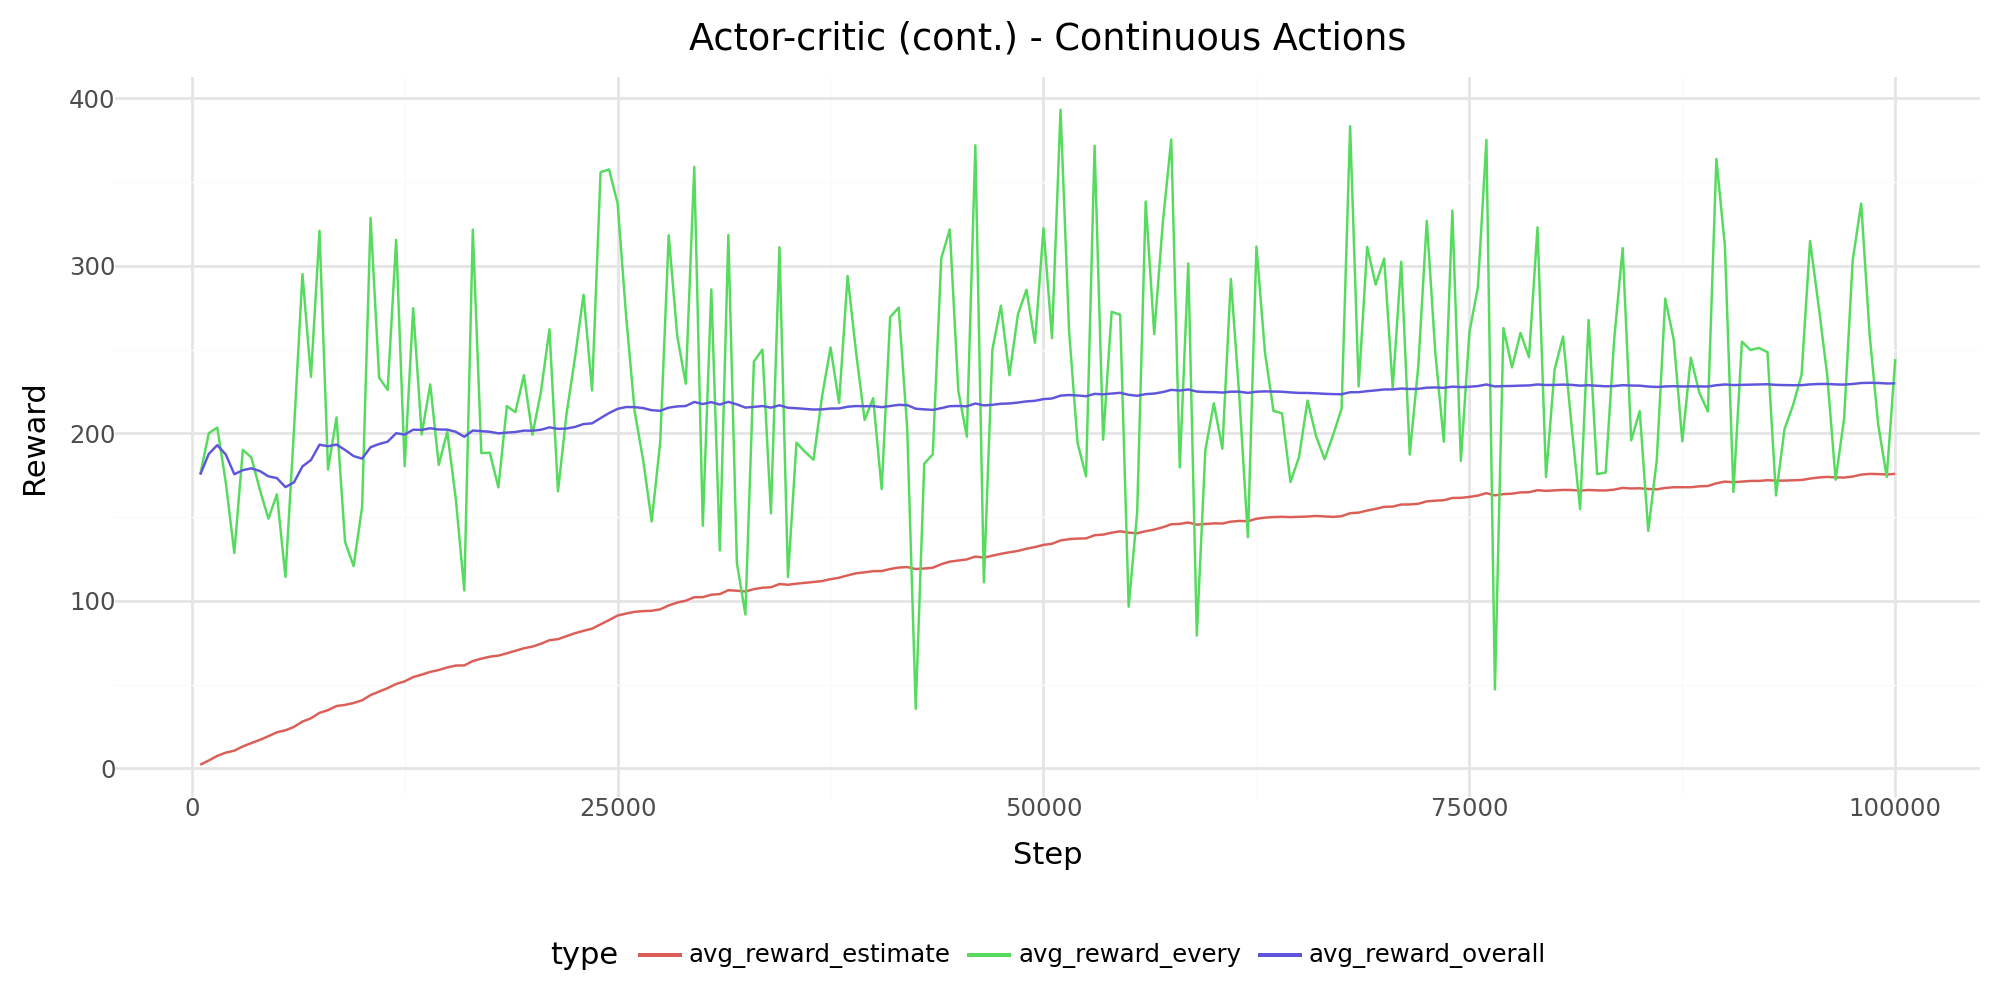

In [ ]:
# Main Execution

if __name__ == "__main__":
    # Load environment
    # from your_module import EnvEnergyCont, settings
    env = EnvEnergyCont(settings)

    # --- hyperparameters (reduced for stability) ---
    alpha_theta = 0.001      # actor step size (reduced)
    alpha_v = 0.01           # critic step size (reduced)
    alpha_r = 1e-4           # average-reward step size
    n_tilings = 8
    tiles_per_dim = [8, 8, 8, 8]
    total_steps = 100000
    callback_every = min(total_steps // 100, 500)

    # --- actor: Gaussian policy with tile coding ---
    pi_hat = GaussianPolicyTileCoding(
        env=env,
        step_size=alpha_theta,
        n_tilings=n_tilings,
        tiles_per_dim=tiles_per_dim,
        sigma=2.0,
        init_mean=5.0,
        rng_seed=878
    )

    # --- critic: value function with tile coding ---
    v_hat = ValueFunctionTileCoding(
        env=env,
        step_size=alpha_v,
        n_tilings=n_tilings,
        tiles_per_dim=tiles_per_dim,
        init_val=0.0,
        seed=249
    )

    # --- run ---
    trace = []
    actor_critic_continuing(
        pi_hat=pi_hat,
        v_hat=v_hat,
        env=env,
        steps=total_steps,
        alpha_r=alpha_r,
        callback=callback,
        callback_every=callback_every,
        trace=trace,
    )

    plot_results_cont(trace, title_r="Actor-critic (cont.) - Continuous Actions")

* The plot is showing how the actor-critic algorithm is learning to trade energy in the continuous action space.
* Green line (avg_reward_every): Average reward over each callback interval, it fluctuates a lot (between 50 and 400 EUR/hour) due to the wind speed and electricity prices
* Red line (avg_reward_estimate): Starts at 0 and ends at 176 EUR on average, slowly converging towards the true mean.
* Blue line (avg_reward_overall): The cumulative average reward from the beginning. Shows improvement from earning approx 180 on average to earning 225 EUR/hour on average over the 100000 steps.

# **Option 2: DeepRL**

In [ ]:
# ==========================================
# EnvEnergyCont (continuous energy environment)
# with cached model loading
# ==========================================
class EnvEnergyCont:
    """
    Environment for the hour-to-hour electricity market problem with continuous actions.
    """

    # Class-level caches so we only download/load once per process
    _model_price = None
    _model_wind = None

    def __init__(self, settings, seed=25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            seed (int): A seed for the random number generator
        """
        self.settings = settings

        # --- price model (cached) ---
        if EnvEnergyCont._model_price is None:
            url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
            output_filename = 'prices_ar1.pkl.gz'
            gdown.download(url, output_filename, quiet=True)
            with gzip.open(output_filename, "rb") as f:
                EnvEnergyCont._model_price = joblib.load(f)
        self.model_price = EnvEnergyCont._model_price

        # --- wind model (cached) ---
        if EnvEnergyCont._model_wind is None:
            url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
            output_filename = 'wind_log_ar1.pkl.gz'
            gdown.download(url, output_filename, quiet=True)
            with gzip.open(output_filename, "rb") as f:
                EnvEnergyCont._model_wind = joblib.load(f)
        self.model_wind = EnvEnergyCont._model_wind

        self.rng = np.random.default_rng(seed)

    def reset_rng(self, seed):
        self.rng = np.random.default_rng(seed)

    def check_s(self, s):
        s_l, s_c, s_w, _ = s
        assert 0 <= s_l <= self.settings['b_max']
        assert -self.settings['b_max'] <= s_c <= self.settings['c_max']
        assert s_w >= 0

    def check_a(self, a):
        a_b, a_w, a_c = a
        assert -self.settings['b_max'] <= a_b <= self.settings['b_max']
        assert a_w >= 0
        assert -self.settings['b_max'] <= a_c <= self.settings['c_max']

    def get_action_info(self, s: tuple) -> tuple:
        """
        Get fixed actions for a given state and the minimum a_c value to choose.
        """
        self.check_s(s)
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']

        # Determine a_b and a_w
        e_max = self.energy(s_w)  # max wind energy we can sell/produce
        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else:  # s_c < e_max:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else:  # s_c < 0:
            a_b = -min(b_max - s_l, -s_c + e_max)
            a_w = max(0, -a_b + s_c)

        a_c_min = -(b_max - (s_l - a_b))  # no need to buy power that cannot be stored
        return float(a_b), float(a_w), float(a_c_min)

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0.0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0.0

    def energy(self, w, time_period_length=1.0):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            r = s_c * s_p - c_plus * abs(s_c - e)
        elif s_p < 0:
            r = s_c * s_p - c_minus * abs(s_c - e)
        else:
            raise ValueError("Reward can not be calculated.")
        return r  # keep raw reward; VecNormalize will normalize during training

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()

        mean_next_price = intercept + phi * price
        std_dev_next_price = sigma

        return self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.
        """
        min_positive_wind = 1e-6
        log_wind = np.log(max(wind, min_positive_wind))

        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()

        log_mean_next_wind = intercept + phi * log_wind
        std_dev_next_wind = sigma

        log_wind_next_sample = self.rng.normal(
            loc=log_mean_next_wind, scale=std_dev_next_wind
        )
        return float(np.exp(log_wind_next_sample))

    def get_step(self, s: tuple, a: tuple):
        """
        Compute one-step transition and reward from (s, a).
        """
        self.check_s(s)
        self.check_a(a)

        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a

        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w))
        s_p_next = float(self.generate_price_next_hour(s_p))

        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        self.check_s(s_next)

        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward


In [ ]:
# ==========================================
# EnergyGym: Gym wrapper for EnvEnergyCont
# ==========================================
class EnergyGym(gym.Env):
    """
    Gym wrapper so we can plug EnvEnergyCont into deep RL libs.
    The task is continuing, so `terminated=False` unless you add a horizon.
    """
    metadata = {"render.modes": []}

    def __init__(self, settings, init_state=None, seed=1234):
        super().__init__()
        self.settings = settings
        self.env = EnvEnergyCont(settings=settings, seed=seed)
        self.rng = np.random.default_rng(seed)
        self.init_state = init_state  # e.g. (b_max/2, 0.0, 6.0, 0.0)

        b_max = settings["b_max"]
        c_max = settings["c_max"]
        w_hi = settings.get("w_cut_out", 30.0)
        p_hi = settings.get("p_max", 200.0)

        self.observation_space = spaces.Box(
            low=np.array([0.0, -b_max, 0.0, -p_hi], dtype=np.float32),
            high=np.array([b_max, c_max, w_hi, p_hi], dtype=np.float32),
            dtype=np.float32,
        )
        self.action_space = spaces.Box(
            low=np.array([-b_max, 0.0, -b_max], dtype=np.float32),
            high=np.array([b_max, w_hi, c_max], dtype=np.float32),
            dtype=np.float32,
        )
        self.state = None

    def _reset_state(self):
        if self.init_state is not None:
            self.state = list(self.init_state)
        else:
            self.state = [
                0.5 * self.settings["b_max"],
                0.0,
                0.5 * self.settings.get("w_rated", 12.0),
                0.0,
            ]

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
            self.env.reset_rng(seed)
        self._reset_state()
        return np.array(self.state, dtype=np.float32), {}

    def step(self, action):
        a_b_raw, a_w_raw, a_c_raw = np.asarray(action, dtype=np.float32)
        b_max = self.settings["b_max"]
        c_max = self.settings["c_max"]

        # Feasibility info from underlying environment
        a_b_fix, a_w_fix, a_c_min = self.env.get_action_info(tuple(self.state))

        s_l = self.state[0]
        # battery safety: keep next level within [0, b_max]
        a_b = np.clip(a_b_raw, -(b_max - s_l), s_l)
        # cannot sell more wind than physically available
        a_w = np.clip(a_w_raw, 0.0, self.env.energy(self.state[2]))
        # contract bounded by feasibility and contract cap
        a_c = np.clip(a_c_raw, a_c_min, c_max)

        next_state, reward = self.env.get_step(tuple(self.state), (a_b, a_w, a_c))
        self.state = next_state

        terminated = False  # continuing task
        truncated = False
        return np.array(self.state, dtype=np.float32), float(reward), terminated, truncated, {}


In [ ]:
# ==========================================
# Settings, env makers, and evaluation callback
# ==========================================
settings = {
    'b_max': 10,       # battery capacity (MWh)
    'p_max': 10,       # max power output wind (MW)
    'c_max': 10 + 10,  # max commitment (MWh) # b_max + p_max
    'w_cut_in': 3,     # cut in wind speed (m/s)
    'w_rated': 12,     # rated wind speed (m/s)
    'w_cut_out': 25,   # cut out wind speed (m/s)
    'c_plus': 50,      # EUR/MWh
    'c_minus': 50,     # EUR/MWh
}

def make_env(seed):
    def _init():
        return EnergyGym(
            settings=settings,
            init_state=(settings['b_max'] / 2, 0.0, 10.0, 0.0),
            seed=seed,
        )
    return _init

# Use multiple environments for faster sampling
n_envs = 4
vec_env_raw = SubprocVecEnv([make_env(seed=i) for i in range(n_envs)])

# Normalize observations and rewards to help the critic
vec_env = VecNormalize(
    vec_env_raw,
    norm_obs=True,
    norm_reward=True,
    clip_reward=10.0,
)

# Separate eval env (no normalization, to measure true avg reward per step)
eval_env = EnergyGym(
    settings=settings,
    init_state=(settings['b_max'] / 2, 0.0, 10.0, 0.0),
    seed=999,
)


class AvgReturnCallback(BaseCallback):
    """
    Logs undiscounted average reward per step over eval episodes.
    Uses the *raw* eval_env (no normalization) to keep metrics interpretable.
    """
    def __init__(self, eval_env, every=2000, eval_episodes=3, verbose=0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.every = every
        self.eval_episodes = eval_episodes
        self.trace = []

    def _on_step(self) -> bool:
        if self.n_calls % self.every == 0:
            returns = []
            for _ in range(self.eval_episodes):
                obs, _ = self.eval_env.reset()
                done = False
                total_r = 0.0
                steps = 0
                while not done and steps < 200:  # finite eval horizon
                    action, _ = self.model.predict(obs, deterministic=True)
                    obs, r, terminated, truncated, _ = self.eval_env.step(action)
                    total_r += r
                    steps += 1
                    done = terminated or truncated
                returns.append(total_r / max(steps, 1))  # average reward per step
            avg_return = float(np.mean(returns))
            self.trace.append({"update": self.n_calls, "avg_return": avg_return})
            if self.verbose > 0:
                print(f"[eval] updates={self.n_calls} avg_return={avg_return:.3f}")
        return True

callback = AvgReturnCallback(eval_env, every=2000, eval_episodes=3, verbose=1)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# ==========================================
# PPO agent (critic-friendly) + decaying learning rate
# ==========================================

# Keep gamma close to 1 to approximate average reward
gamma = 0.9999

# Learning rate schedule: start higher, decay over time
def linear_lr_schedule(initial_lr: float, final_lr: float = 3e-5):
    def lr_schedule(progress_remaining: float) -> float:
        # progress_remaining goes from 1.0 (start) to 0.0 (end)
        return final_lr + (initial_lr - final_lr) * progress_remaining
    return lr_schedule

initial_lr = 3e-4

# Network for policy & value
policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=[64, 64],
)

device = "cuda" if th.cuda.is_available() else "cpu"
print("Using device:", device)

model = PPO(
    "MlpPolicy",
    vec_env,
    gamma=gamma,
    learning_rate=linear_lr_schedule(initial_lr, final_lr=3e-5),
    policy_kwargs=policy_kwargs,
    batch_size=64,
    n_steps=512,      # 512 * n_envs steps per update
    n_epochs=4,       # fewer epochs for speed
    gae_lambda=0.9,   # smoother, lower-variance advantages
    vf_coef=1.0,      # critic has more weight in the loss
    max_grad_norm=0.5,
    verbose=1,
    device=device,
)

total_timesteps = 2_000_000
model.learn(total_timesteps=total_timesteps, callback=callback)

trace_avg = callback.trace


Using device: cuda
Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Streaming af output blev afkortet til de sidste 5000 linjer.
|    approx_kl            | 0.005115211 |
|    clip_fraction        | 0.0476      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.84       |
|    explained_variance   | 0.574       |
|    learning_rate        | 0.000102    |
|    loss                 | 0.0783      |
|    n_updates            | 2868        |
|    policy_gradient_loss | -0.000253   |
|    std                  | 0.453       |
|    value_loss           | 0.0684      |
-----------------------------------------
[eval] updates=368000 avg_return=496.509
-----------------------------------------
| time/                   |             |
|    fps                  | 609         |
|    iterations           | 719         |
|    time_elapsed         | 2417        |
|    total_timesteps      | 1472512     |
| train/                  |             |
|    approx_kl            | 0.005748665 |
|    clip_fraction        | 0.0575      |
|    clip_range 

**fps** = frame environment steps per second = 608 (Ran on T4 GPU)

**approx_kl** = 0.00489 (should be between 0.01-0.03 meaning the policy is changing at a reasonable pace)

**clip_fraction** = 0.0343 (clipping prevents updates from being too large should be between 0.01-0.2) The value of 0.0343 is good which means clipping happens sometimes but not too often

**entropy_loss**=-1.57
(this is the amount of exploration the higher the value the more exploration. This means that the policy still explored a lot in the end and is not very deterministic) This is further evidence for the model not being run for enough time probably.

**explained_variance** = 0.599 (measures how well the value function predicts returns) our value of 0.599 means that we can explain most of the variance but there should still be more performance to be found.

**learning_rate** = 3.02e-5 (This is a learning rate which starts large and then gradually increases, this was done on the second run, in the first run it was locked at 0.003 and we didnt see any large improvements)

**n_updates** = 3904 (total number of minibatch gradient updates performed)

**policy_gradient_loss** = -0.0031 (shows how the policy parameters are adjusting. negative values, as in this case, means PPO is improving performance, and small values indicate stable policy changes) again further signs that further performance could be found

**std** = 0.415
(This is the standard deviation of the Gaussian action distribution we are close to 1 meaning our policy still explores a lot, this is evidence for the model might needing more training)

**value_loss** = 0.137 (how poorly the value function is predicting returns) we want this value to be between 0.05 and 0.5


Summary (undiscounted avg reward per step on eval env):
  Final avg reward per step: 303.4047
  Best  avg reward per step: 966.7853
  Mean  avg reward per step: 484.7213


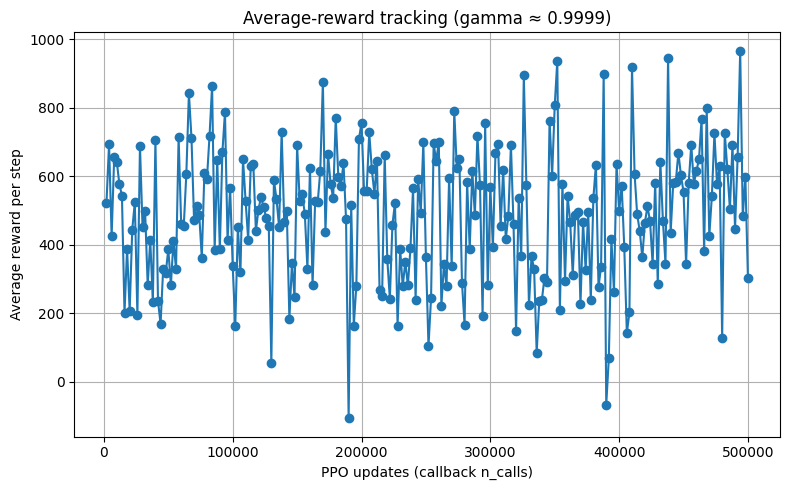

In [ ]:
# ==========================================
# Summary statistics + plot (average reward trace)
# ==========================================
df = pd.DataFrame(trace_avg)

if len(df) == 0:
    print("No evaluation data collected. Try lowering 'every' in AvgReturnCallback.")
else:
    final_avg = df["avg_return"].iloc[-1]
    best_avg = df["avg_return"].max()
    mean_avg = df["avg_return"].mean()

    print("\nSummary (undiscounted avg reward per step on eval env):")
    print(f"  Final avg reward per step: {final_avg:.4f}")
    print(f"  Best  avg reward per step: {best_avg:.4f}")
    print(f"  Mean  avg reward per step: {mean_avg:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(df["update"], df["avg_return"], marker="o")
    plt.xlabel("PPO updates (callback n_calls)")
    plt.ylabel("Average reward per step")
    plt.title("Average-reward tracking (gamma ≈ 0.9999)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


After the changes to the model (outlined below) we can see that the model performs much better, previously the best average reward per step was around 100.

**Initial training difficulties and critic instability**

Before introducing the revised DeepRL configuration, the training process showed clear signs of critic instability.

Across multiple runs, the value network consistently produced highly negative explained variance estimates (in the range of −3 to −9), indicating that the critic’s predictions were worse than using a constant baseline. The value loss remained extremely large (10^8 to 10^9), suggesting that the scale and variability of the unnormalised returns were overwhelming the value function.

As a consequence, the advantage estimates became noisy and unreliable, leading to very small policy gradient updates. This was reflected in near-zero KL divergence, negligible clipping activity, and a policy standard deviation that remained close to its initial value (≈ 1.0) even late in training.

In practice, this meant that the policy was barely improving despite long training runs, and both the actor and critic were effectively stuck.

**DeepRL configuration and critic-oriented adjustments**

In the DeepRL setup, we used PPO with a near-undiscounted objective (γ = 0.9999) to approximate the average-reward criterion. Several modifications were made to improve the stability and performance of the critic.

First, the training environment was wrapped with a VecNormalize to normalise both observations and rewards. This reduces the scale and variance of the target values that the value network must learn, making the regression problem better conditioned.

Second, we increased the relative weight of the value loss in the PPO objective by setting vf_coef = 1.0 and applied gradient clipping (max_grad_norm = 0.5) to prevent excessively large parameter updates.

Third, we adjusted the advantage estimation by setting gae_lambda = 0.9, which yields smoother, lower-variance advantage estimates by placing slightly more emphasis on shorter-term TD errors.

To improve optimisation over a long training run, we also replaced the constant learning rate with a linearly decaying schedule as training progresses, allowing for relatively aggressive updates early on and more conservative, fine-tuning updates later.

# **Classical TD Actor–Critic**

Updates online and step-by-step: both the policy and value estimates are updated after every interaction with the environment.

Explicitly learns the average reward (the differential value function), meaning it keeps a running estimate of how good performance is per time step.

Uses simple function approximators (e.g., linear, polynomial, Fourier bases), which are efficient but limited in when trying to fit to complex spaces.

The algorithm is highly reactive. It immediately adjusts the policy when small changes occur in the environment.

The learning signal (TD-error + average reward estimate) is updated continuously, so the agent always has an up-to-date sense of performance.

**Analogy**
Student example: Imagine a student who checks their running average after every quiz question.
“I’m at 65% right now—I need to adjust how I approach the next problem.”

Cycling example: A cyclist (e.g., Vingegaard) constantly looks at real-time watt/kg and adjusts effort immediately for the next minute.

**Summary**
The TD actor–critic is online, incremental, and average-reward driven, with simple models and continuous, reactive adjustment.

# **Deep Reinforcement Learning (PPO Implementation)**

PPO is not built for average-reward optimisation.
To approximate that setting, the script “fakes” average reward by using a very high discount factor (e.g., γ = 0.9999).

Learning is batch-based: the agent collects entire trajectories, then updates the networks using multiple gradient steps.

PPO uses deep neural networks (policy + value), allowing it to capture complex nonlinear patterns.

Advantage estimation uses GAE, providing smoother and more stable estimates than classical TD updates.

In continuous action environments, PPO’s policy outputs Gaussian parameters (mean and log-std), enabling fine-grained control.

The algorithm is less reactive. Performance is not evaluated after each step; instead it is assessed after full batches/episodes.

Average reward is not tracked during training—it is only computed after training, unlike differential actor–critic.

Deep networks allow for richer representations but require more data, computation, and batch updates.

**Analogy**
Student example: A student reads entire chapters and only then checks how well they understood the material.
Adjustments are based on patterns over many pages, not moment-to-moment feedback.

Cycling example: Performance is evaluated after several kilometres or an entire race rather than after every kilometre.

**Summary**
PPO optimises a discounted surrogate objective, learns using batches rather than online updates, relies on deep nonlinear networks, and only approximates average-reward behaviour through a large discount factor.

# **Option 3: Fourier transformation**

Although the environment is continuous, in this example we discretise the agent’s action dimension to make learning easier and more stable. This introduces a small approximation error, because the agent can only choose from a finite grid of actions, but it results in much faster learning.

In [ ]:
##Loading continous environment (identical to the one we were given)
class EnvEnergyCont:
    """
    Environment for the hour-to-hour electricity market problem with continuous actions.
    """

    def __init__(self, settings, seed = 25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            seed (int): A seed for the random number generator
        """
        self.settings = settings

        ## price model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        # Output filename for the downloaded file
        output_filename = 'prices_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        print(f"Price model loaded successfully from {output_filename}")
        self.model_price = model_price

        ## wind model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        # Output filename for the downloaded file
        output_filename = 'wind_log_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        print(f"Wind model loaded successfully from {output_filename}")
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)

    def reset_rng(self, seed):
        """
        Reset the random number generator.

        Args:
            seed (int): A seed for the random number generator
        """
        self.rng = np.random.default_rng(seed)

    def check_s(self, s):
        """
        Check if a state is valid.
        """
        s_l, s_c, s_w, _ = s
        assert s_l >= 0 and s_l <= self.settings['b_max']
        assert s_c >= -self.settings['b_max'] and s_c <= self.settings['c_max']
        assert s_w >= 0

    def check_a(self, a):
        """
        Check if an action is valid.
        """
        a_b, a_w, a_c = a
        assert a_b >= -self.settings['b_max'] and a_b <= self.settings['b_max']
        assert a_w >= 0
        assert a_c >= -self.settings['b_max'] and a_c <= self.settings['c_max']

    def get_action_info(self, s: tuple) -> tuple:
        """
        Get fixed actions for a given state and the minimum a_c value to choose.
        """
        self.check_s(s)
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']
        # Determine a_b and a_w
        e_max = self.energy(s_w) # max wind energy we can sell/produce
        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else: # s_c < e_max:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else: # s_c < 0:
            a_b = -min(b_max - s_l, - s_c + e_max)
            a_w = max(0, - a_b + s_c)
        # print(f"s_c: {s_c},  s_w: {s_w}, e_max: {e_max}")
        # print(f"s_l: {s_l}, a_b: {a_b}, a_w: {a_w}, min a_c: {-(b_max - (s_l - a_b))}")
        a_c_min = -(b_max - (s_l - a_b))  # no need to buy power that cannot be stored
        return float(a_b), float(a_w), float(a_c_min)

    def state_variables_to_str(self, s_l, s_c, s_w, s_p):
        """
        String representaion of a state.
        """
        return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

    def action_variables_to_str(self, a_b, a_w, a_c):
        """
        String representaion of an action.
        """
        return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        if s_p < 0:
            return s_c * s_p - c_minus * abs(s_c - e)
        raise ValueError("Reward can not be calculated.")

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.

        Args:
            price (float): The current price.

        Returns:
            float: A random sample of the next hour's price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        # The mean of the next price's distribution is the predicted value
        mean_next_price = intercept + phi * price
        # The standard deviation of the next price's distribution is the residual standard deviation
        std_dev_next_price = sigma
        # Generate a random sample from a normal distribution
        price_next_sample = self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)
        return price_next_sample

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.

        Args:
            wind (float): The current wind speed.

        Returns:
            float: A random sample of the next hour's wind speed.
        """
        # Add a small epsilon to prevent log(0) if wind is zero.
        # This ensures numerical stability for the log-transformed AR(1) model.
        min_positive_wind = 1e-6 # A very small positive number to avoid log(0)
        log_wind = np.log(max(wind, min_positive_wind))
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        # The mean of the next wind speed's distribution is the predicted value
        log_mean_next_wind = intercept + phi * log_wind
        # The standard deviation of the next wind speed's distribution is the residual standard deviation
        std_dev_next_wind = sigma
        # Generate a random sample from a normal distribution
        log_wind_next_sample = self.rng.normal(loc=log_mean_next_wind, scale=std_dev_next_wind)
        return np.exp(log_wind_next_sample)

    def get_step(self, s: tuple, a: tuple):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label
            a: Action label

        Returns:
            tuple: (sN, r)
        """
        self.check_s(s)
        self.check_a(a)
        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a
        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w)) # update current values
        s_p_next = float(self.generate_price_next_hour(s_p))
        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        self.check_s(s_next)
        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward

Making actor critic with fourier transformations

In [ ]:
import numpy as np

class FourierActorCritic:
    """
    Actor-Critic using Fourier features for EnvEnergyCont.
    Only the next commitment a_c is treated as an action; a_b and a_w are
    deterministic via get_action_info().
    Fully continuous training ready.
    """
    ##We set gamma high simulating a continuing task. learning rates are adjusted later.
    def __init__(self, env, order=3, alpha_actor=1e-4, alpha_critic=1e-4, gamma=0.99999, rng_seed=42):
        self.env = env
        self.order = order
        self.alpha_actor = alpha_actor
        self.alpha_critic = alpha_critic
        self.gamma = gamma
        self.rng = np.random.default_rng(rng_seed)

        # Fourier features for states: s = [s_l, s_c, s_w, s_p]
        ks = []
        for k0 in range(order+1):
            for k1 in range(order+1):
                for k2 in range(order+1):
                    for k3 in range(order+1):
                        ks.append((k0, k1, k2, k3))
        self.k = np.array(ks, dtype=float)
        self.num_features = self.k.shape[0]

        # Actor: discretize a_c uniformly from 0 to c_max
        c_max = env.settings['c_max']
        self.a_c_values = np.linspace(0, c_max, 21)   # 21 evenly spaced actions (could be anything)
        self.num_actions = len(self.a_c_values)
        self.theta = np.zeros((self.num_actions, self.num_features))

        # Critic: value function weights
        self.w = np.zeros(self.num_features)

        # Normalization
        self.s_max = np.array([env.settings['b_max'], env.settings['c_max'], 100.0, 200.0])  # rough guesses of max wind/price for normalization
        self.s_min = self.s_min = np.array([0.0, -b_max, 0.0, -200]) #Can't be only zeros, as prices and battery can become negative

    # -------------------------
    def fourier_features(self, s):
        s = np.array(s)
        s_bar = (s - self.s_min) / (self.s_max - self.s_min)
        proj = self.k @ s_bar
        return np.cos(np.pi * proj) #feature vector used for actor and critic

    def softmax(self, prefs):
        c = np.max(prefs)
        exp_p = np.exp(prefs - c)
        return exp_p / np.sum(exp_p) #Wouldn't be able to use softmax without discrete a_c

    def get_action_probs(self, s):
        phi = self.fourier_features(s)
        prefs = self.theta @ phi
        return self.softmax(prefs) #compute fourier features (returns softmax probs over a_c)

    def sample_action(self, s):
        probs = self.get_action_probs(s)
        idx = self.rng.choice(self.num_actions, p=probs)
        return self.a_c_values[idx], idx #Draws an action from the softmax

    # -------------------------
    def train_continuous(self, n_steps, log_every=1000):
        """
        Fully continuous training loop. No episodes; state carries on.
        Logs mean reward per step.
        """
        s = [self.env.settings['b_max'], 0.0, 10.0, 20.0]  # initial state
        total_reward = 0.0
        trace = []

        print(f"Starting continuous training for {n_steps} steps, logging every {log_every} steps.")

        for t in range(1, n_steps + 1):
            # Sample action and compute feasible action
            a_c, a_idx = self.sample_action(s)
            a_b, a_w, a_c_min = self.env.get_action_info(s)
            a_c_clipped = np.clip(a_c, a_c_min, self.env.settings['c_max'])
            a = (a_b, a_w, a_c_clipped)

            # Step environment
            s_next, r = self.env.get_step(s, a)
            total_reward += r

            # TD error & updates
            phi_s = self.fourier_features(s)
            phi_s_next = self.fourier_features(s_next)
            delta = r + self.gamma * (self.w @ phi_s_next) - (self.w @ phi_s)

            # Critic update
            self.w += self.alpha_critic * delta * phi_s

            # Actor update
            probs = self.get_action_probs(s)
            grad = -probs
            grad[a_idx] += 1.0
            self.theta += self.alpha_actor * delta * np.outer(grad, phi_s)

            # Move to next state
            s = s_next

            # Logging
            if t % log_every == 0:
                mean_reward = total_reward / t
                trace.append({'step': t, 'mean_reward': mean_reward})
                print(f"Step {t}: mean reward = {mean_reward:.4f}")

        return trace

In [ ]:
# --- Training Function for Logging ---
def train_and_log_continuous(agent, n_steps, log_every=1000, title_r=""):
    s = [agent.env.settings['b_max'], 0.0, 10.0, 20.0]  # initial state
    total_reward = 0.0
    trace = []

    print(f"Starting continuous training with logging (Total steps: {n_steps}, Log every: {log_every})")

    for t in range(1, n_steps + 1):
        # Sample Action, Step Env, and Update Agent (as in your original continuous loop)
        a_c, a_idx = agent.sample_action(s)
        a_b, a_w, a_c_min = agent.env.get_action_info(s)
        a_c_clipped = np.clip(a_c, a_c_min, agent.env.settings['c_max'])
        a = (a_b, a_w, a_c_clipped)

        s_next, r = agent.env.get_step(s, a)
        total_reward += r

        # TD error & updates
        phi_s = agent.fourier_features(s)
        phi_s_next = agent.fourier_features(s_next)
        delta = r + agent.gamma * (agent.w @ phi_s_next) - (agent.w @ phi_s)
        agent.w += agent.alpha_critic * delta * phi_s # Critic
        probs = agent.get_action_probs(s)
        grad = -probs
        grad[a_idx] += 1.0
        agent.theta += agent.alpha_actor * delta * np.outer(grad, phi_s) # Actor
        s = s_next

        # --- Logging Trace Data ---
        if t % log_every == 0:
            current_mean_reward = total_reward / t
            trace.append({
                'step': t,
                'mean_reward': current_mean_reward,
                # Optionally add a rolling mean:
                # 'rolling_reward': calculate_rolling_mean()
            })
            print(f"Step {t}: Mean reward = {current_mean_reward:.4f}")

    return trace

# --- Execution ---
env = EnvEnergyCont(settings)
agent = FourierActorCritic(env, order=3, alpha_actor=1e-5, alpha_critic=1e-5, gamma=0.99999) #changed learning rate

trace_ac_cont = train_and_log_continuous(agent, n_steps=100_000, log_every=1000) #changed steps

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz
Starting continuous training with logging (Total steps: 100000, Log every: 1000)
Step 1000: Mean reward = 325.4238
Step 2000: Mean reward = 357.7606
Step 3000: Mean reward = 345.8923
Step 4000: Mean reward = 343.0291
Step 5000: Mean reward = 333.8514
Step 6000: Mean reward = 318.7583
Step 7000: Mean reward = 364.2497
Step 8000: Mean reward = 393.1722
Step 9000: Mean reward = 384.1381
Step 10000: Mean reward = 373.3104
Step 11000: Mean reward = 405.7594
Step 12000: Mean reward = 429.6652
Step 13000: Mean reward = 441.1241
Step 14000: Mean reward = 447.7515
Step 15000: Mean reward = 448.8670
Step 16000: Mean reward = 436.2746
Step 17000: Mean reward = 449.4226
Step 18000: Mean reward = 445.1481
Step 19000: Mean reward = 449.2386
Step 20000: Mean reward = 453.7752
Step 21000: Mean reward = 462.0034
Step 22000: Mean reward = 461.2851
Step 23000: Mean reward = 471.4269
Step 24000: 

In [ ]:
def plot_results_cont(pi_hat, trace, title_r = "", print_dist = False, plot_policy = True):
    # This assumes 'pi_hat' is your agent instance, and 'trace' is your reward data
    dat_r = pd.DataFrame(trace)
    cols_to_gather = [c for c in dat_r.columns if "reward" in c]
    dat_r = dat_r >> gather('type', 'r', cols_to_gather)
    pt = (
        ggplot(dat_r, aes("step", "r", color = "type"))
        + geom_line()
        + theme_minimal()
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(
            title=title_r,
            x="Step",
            y="Reward",
        )
    )
    pt.show()

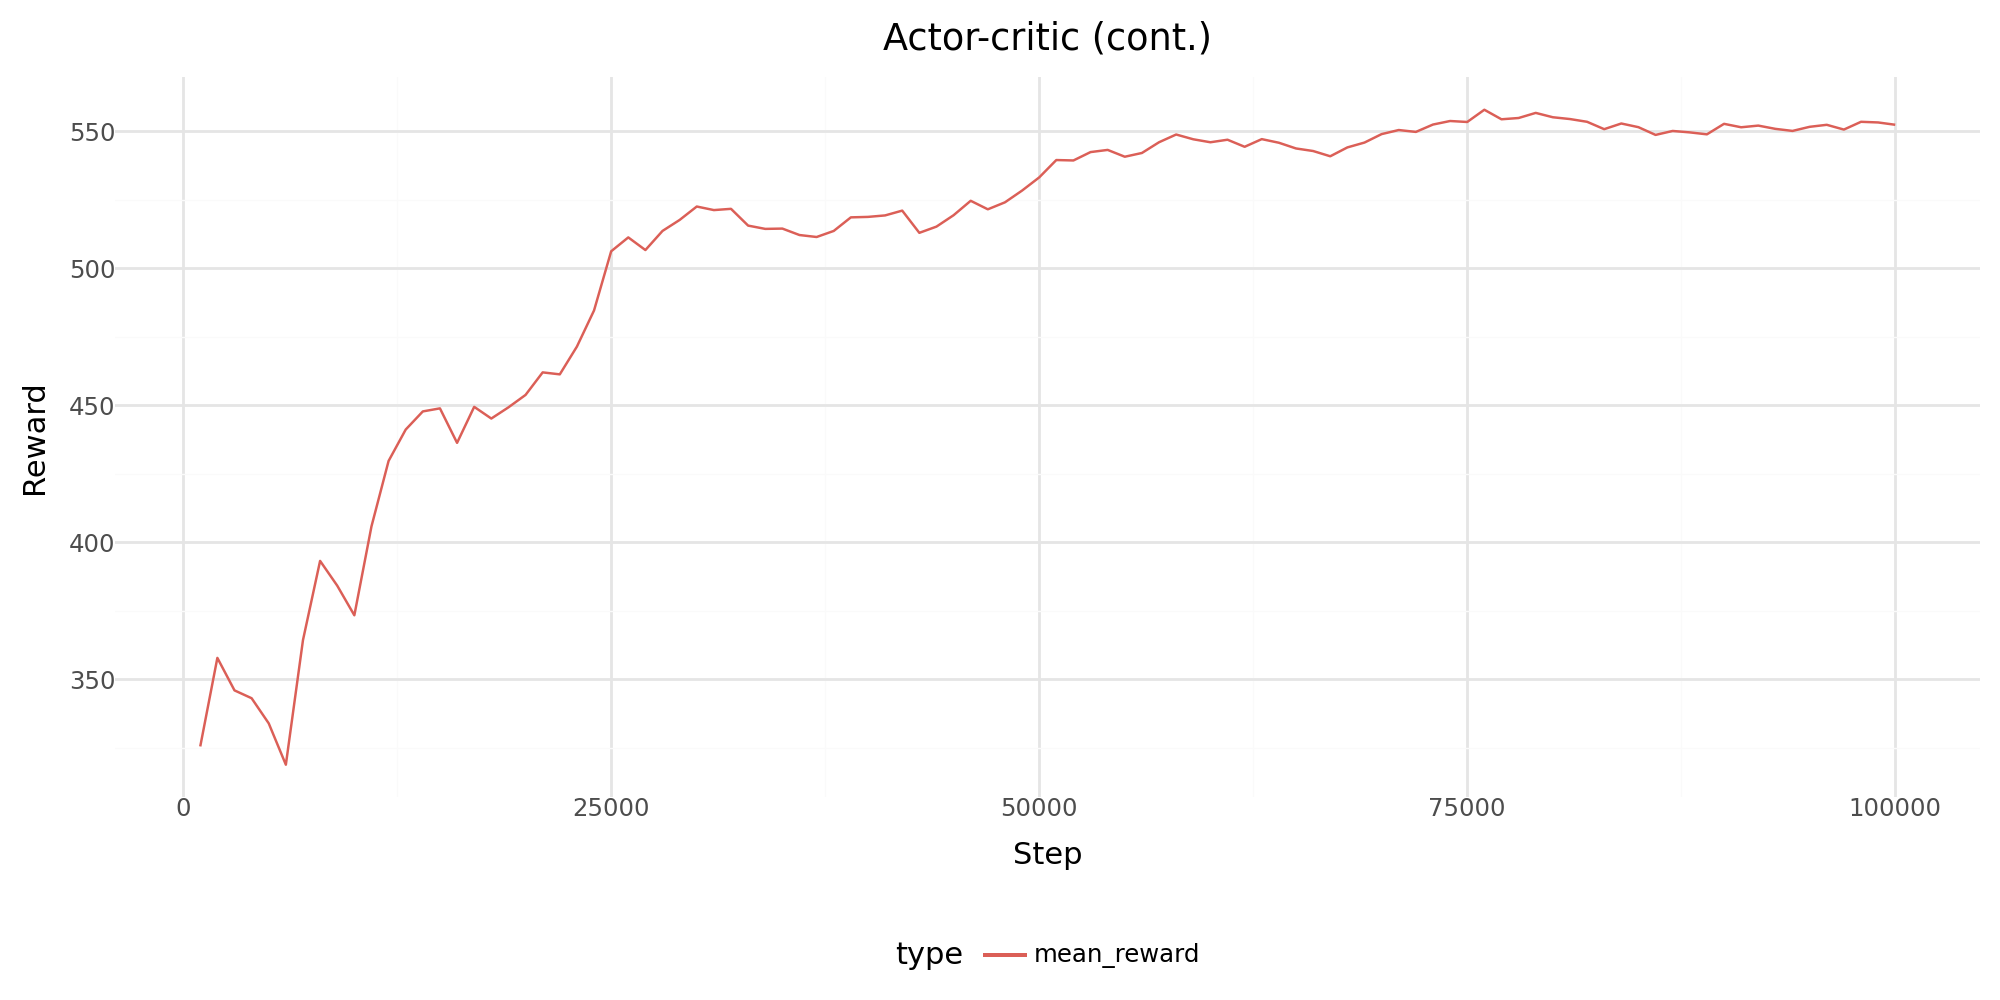

In [ ]:
plot_results_cont(agent, trace_ac_cont, title_r = "Actor-critic (cont.)", plot_policy=False)

Here, we solve the continuous environment using a Fourier actor-critic approach. Fourier features are used to approximate both the actor and the critic with linear function approximation, allowing highly nonlinear functions of the state to be represented. We set a very high discount factor to simulate a continuing task.

To enable the use of softmax, we discretize a_c, which makes learning easier at the cost of some approximation error. The critic computes the TD error at each step, which is then used to update the actor policy via gradient ascent. State variables are normalized, and Fourier basis functions capture nonlinearities in the value function.

The agent is trained in a fully continuous loop, and the actor successfully learns a stable policy, reaching an average reward around 552 after 100,000 steps.